# Delivery Route Optimization using Reinforcement Learning and AI Assistance

## Overview
This notebook demonstrates how to optimize delivery routes using various reinforcement learning algorithms (Q-Learning, SARSA, DQN) with the assistance of a Google Gemini AI model for generating locations and hyperparameter tuning recommendations. The environment simulates a delivery scenario in a specified city using OpenStreetMap (OSM) data.

### Import Required Libraries and Modules

In [51]:
import json
import os

import numpy as np
from IPython.display import display, Markdown
from dotenv import load_dotenv

from dqn import DQNAgent
from environment import DeliveryEnvironment
from google_LLM import GoogleAIModelExplainer
from osm_client import OSMClient
from q_learning import QLearningAgent
from sarsa import SarsaAgent
from visualize import plot_learning_curves, plot_comparison, plot_osmnx_route, plot_tuning_impact, plot_delivery_route

### Helper function - Generate random locations

In [52]:
# Cell 2: Helper function - Generate random locations
def generate_random_locations(city_name, num_locations):
    """
    Generates random coordinates within a given city's bounding box using OSM.
    """
    print(f"Falling back to generating random 'live' locations in {city_name}...")
    osm = OSMClient()
    bbox = osm.get_bounding_box(city_name)
    if not bbox:
        print(f"Could not find bounding box for {city_name}. Exiting.")
        return None

    min_lat, max_lat, min_long, max_long = bbox
    lats = np.random.uniform(min_lat, max_lat, num_locations)
    longs = np.random.uniform(min_long, max_long, num_locations)

    locations = np.vstack((lats, longs)).T
    print(f"Generated {num_locations} random locations in {city_name}.")
    return locations

### Training and Evaluation Functions

In [53]:
def train_agent(agent, env, num_episodes, is_dqn=False):
    """A unified training function for all agent types."""
    reward_history = []
    for episode in range(num_episodes):
        state = env.reset(vectorized=is_dqn)
        done = False
        total_reward = 0

        action = agent.choose_action(state, env.get_possible_actions())

        while not done:
            if action is None: break

            next_state_tuple, reward, done = env.step(action)

            if is_dqn:
                next_state = env._get_state(vectorized=True)
                agent.add_experience(state, action, reward, next_state, done)
                agent.update_model()
            else:
                next_state = next_state_tuple
                next_possible_actions = env.get_possible_actions()
                if isinstance(agent, SarsaAgent):
                    next_action = agent.choose_action(next_state, next_possible_actions)
                    agent.update_q_table(state, action, reward, next_state, next_action)
                    action = next_action
                else:  # Q-Learning
                    agent.update_q_table(state, action, reward, next_state, next_possible_actions)

            if not isinstance(agent, SarsaAgent):
                action = agent.choose_action(next_state, env.get_possible_actions())

            state = next_state
            total_reward += reward

        agent.decay_epsilon()
        reward_history.append(total_reward)
    return reward_history

### Helper function - Evaluate agent

In [54]:
def evaluate_agent(agent, env, is_dqn=False):
    state = env.reset(vectorized=is_dqn)
    route = [env.start_pos_index]
    total_distance = 0

    while len(route) <= env.num_locations:
        possible_actions = env.get_possible_actions()
        if not possible_actions: break

        original_epsilon = agent.epsilon
        agent.epsilon = 0.0
        action = agent.choose_action(state, possible_actions)
        agent.epsilon = original_epsilon

        if action is None: break

        distance = env.distance_matrix[env.current_pos_index][action]
        total_distance += distance
        route.append(action)

        state, _, _ = env.step(action)
        if is_dqn:
            state = env._get_state(vectorized=True)

    if route[-1] != env.start_pos_index:
        total_distance += env.distance_matrix[route[-1]][env.start_pos_index]
        route.append(env.start_pos_index)

    return route, total_distance / 1000

### Main Execution - Configuration and Initialization

In [55]:
# --- CONFIGURATION ---
CITY = "Middlesbrough"
NUM_PARCELS = 10
DISTANCE_METRIC = 'network'
NUM_EPISODES_TUNE = 500
NUM_EPISODES_FINAL = 2000

# Load environment variables
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY", "")

# --- 1. INITIALIZE AI & LOCATIONS ---
explainer = GoogleAIModelExplainer()
locations_list = None
if explainer.available:
    print(f"Using Gemini to generate {NUM_PARCELS + 1} locations in {CITY}...")
    locations_list = explainer.generate_locations_for_city(CITY, NUM_PARCELS + 1)

if locations_list:
    env = DeliveryEnvironment(addresses=locations_list, city_name=CITY, distance_metric=DISTANCE_METRIC)
else:
    locations_coords = generate_random_locations(CITY, NUM_PARCELS + 1)
    if locations_coords is None:
        raise Exception("Failed to generate locations. Exiting.")
    env = DeliveryEnvironment(locations=locations_coords, city_name=CITY, distance_metric=DISTANCE_METRIC)

Using Gemini to generate 11 locations in Middlesbrough...
Failed to generate locations with AI. Error: 404 models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.
Falling back to generating random 'live' locations in Middlesbrough...
Generated 11 random locations in Middlesbrough.
Graph downloaded.
Calculating network distance matrix (this may take a while)...


In [56]:
# Cell 6: Initialize agents
agents = {
    "Q-Learning": QLearningAgent(action_space=list(range(env.num_locations))),
    "SARSA": SarsaAgent(action_space=list(range(env.num_locations))),
    "DQN": DQNAgent(state_size=env.get_state_size(), action_size=env.num_locations)
}

# Display environment info
print(f"Environment initialized with {env.num_locations} locations")
print(f"Distance matrix shape: {env.distance_matrix.shape}")

Environment initialized with 11 locations
Distance matrix shape: (11, 11)


In [57]:
# Cell 7: Initial Training & Hyperparameter Tuning
tuned_params = {}
initial_reward_histories = {}
print("\n--- Initial Training & Hyperparameter Tuning ---")
for name, agent in agents.items():
    print(f"Training {name} for tuning...")
    initial_reward_histories[name] = train_agent(agent, env, NUM_EPISODES_TUNE, isinstance(agent, DQNAgent))

    if explainer.available:
        print(f"Asking Gemini for hyperparameter recommendations for {name}...")
        recommendations = explainer.provide_hyperparameter_recommendations(name, initial_reward_histories[name])
        if isinstance(recommendations, dict):
            tuned_params[name] = recommendations
            print(f"  > AI recommends: {recommendations}")
        else:
            print(f"  > Could not get AI recommendations for {name}.")
            tuned_params[name] = {}
    else:
        tuned_params[name] = {}


--- Initial Training & Hyperparameter Tuning ---
Training Q-Learning for tuning...
Asking Gemini for hyperparameter recommendations for Q-Learning...
  > Could not get AI recommendations for Q-Learning.
Training SARSA for tuning...
Asking Gemini for hyperparameter recommendations for SARSA...
  > Could not get AI recommendations for SARSA.
Training DQN for tuning...
Asking Gemini for hyperparameter recommendations for DQN...
  > Could not get AI recommendations for DQN.


In [58]:
# Cell 8: Optimized Training Run
print("\n--- Optimized Training Run ---")
final_results = {}
optimized_reward_histories = {}
best_route_info = {"agent": None, "route": [], "distance": float('inf')}

# Re-initialize agents to apply new params from scratch
agents = {
    "Q-Learning": QLearningAgent(action_space=list(range(env.num_locations))),
    "SARSA": SarsaAgent(action_space=list(range(env.num_locations))),
    "DQN": DQNAgent(state_size=env.get_state_size(), action_size=env.num_locations)
}

for name, agent in agents.items():
    if name in tuned_params:
        for param, value in tuned_params[name].items():
            if hasattr(agent, param):
                setattr(agent, param, value)
                print(f"  Applied {param} = {value} to {name}")

    print(f"Training {name} with optimized parameters...")
    optimized_reward_histories[name] = train_agent(agent, env, NUM_EPISODES_FINAL, isinstance(agent, DQNAgent))

    route, distance = evaluate_agent(agent, env, isinstance(agent, DQNAgent))
    final_results[name] = {
        "total_distance_km": distance,
        "avg_reward": np.mean(optimized_reward_histories[name][-100:])
    }

    if distance < best_route_info["distance"]:
        best_route_info = {"agent": name, "route": route, "distance": distance}


--- Optimized Training Run ---
Training Q-Learning with optimized parameters...
Training SARSA with optimized parameters...
Training DQN with optimized parameters...


In [59]:
# Cell 9: Final AI Analysis
if explainer.available:
    print("\n--- Final AI-Powered Analysis ---")
    env_config = env.get_environment_summary()
    env_config["episodes"] = NUM_EPISODES_FINAL
    analysis = explainer.analyze_performance(final_results, env_config)
    display(Markdown(analysis))
else:
    print("\n--- Final Results (Local Analysis) ---")
    print(json.dumps(final_results, indent=2))


--- Final AI-Powered Analysis ---


Google AI analysis failed: 404 models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.

In [60]:
# Cell 10: Optimized Delivery Sequence
print("\n--- Optimized Delivery Sequence ---")
print(f"Best Algorithm: {best_route_info['agent']}")
print(f"Total Distance: {best_route_info['distance']:.2f} km")
print("Route:")
for step, loc_index in enumerate(best_route_info["route"]):
    address = env.addresses[loc_index]
    if step == 0:
        print(f"  Start: {address}")
    elif step == len(best_route_info["route"]) - 1:
        print(f"  End:   {address} (Return to Depot)")
    else:
        print(f"  {step}.     {address}")


--- Optimized Delivery Sequence ---
Best Algorithm: DQN
Total Distance: 51.50 km
Route:
  Start: Location 0
  1.     Location 4
  2.     Location 10
  3.     Location 9
  4.     Location 7
  5.     Location 3
  6.     Location 1
  7.     Location 2
  8.     Location 8
  9.     Location 6
  10.     Location 5
  End:   Location 0 (Return to Depot)



--- Generating Visualizations ---


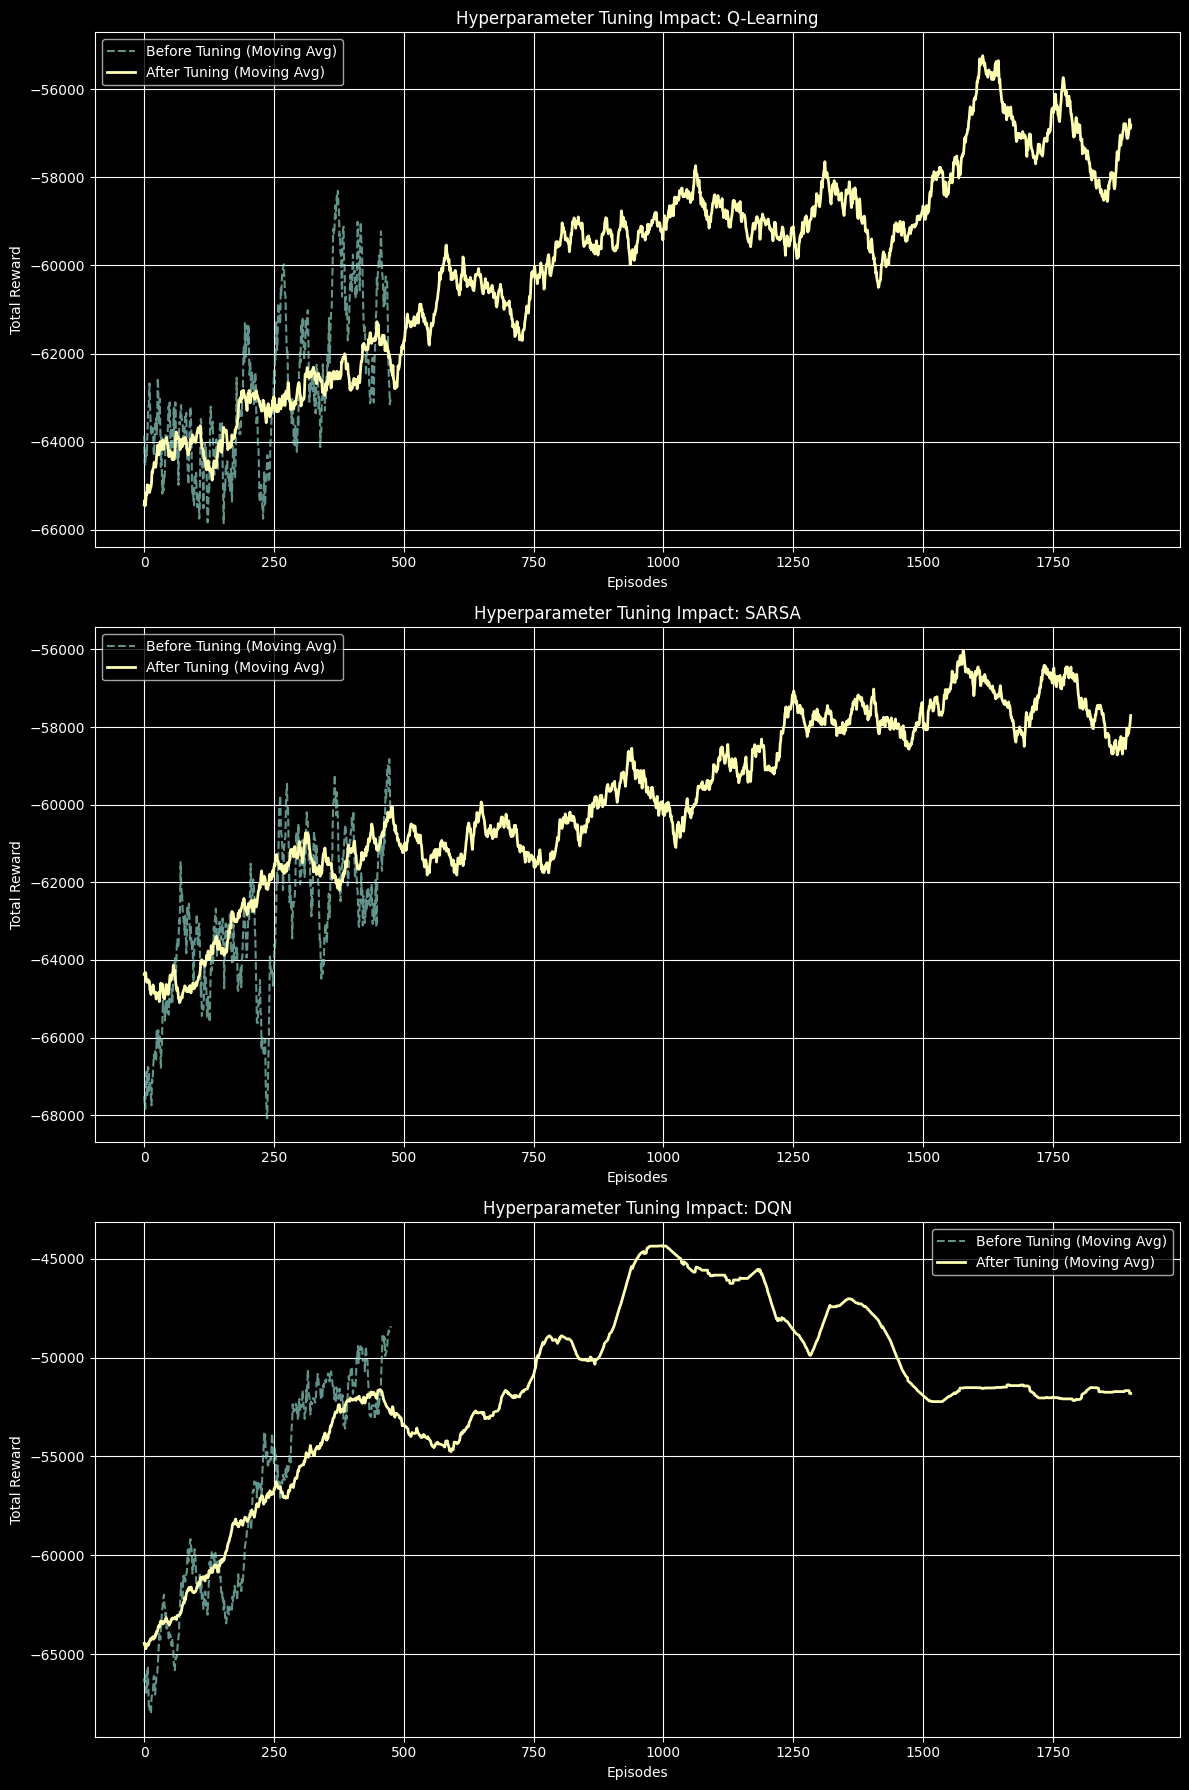

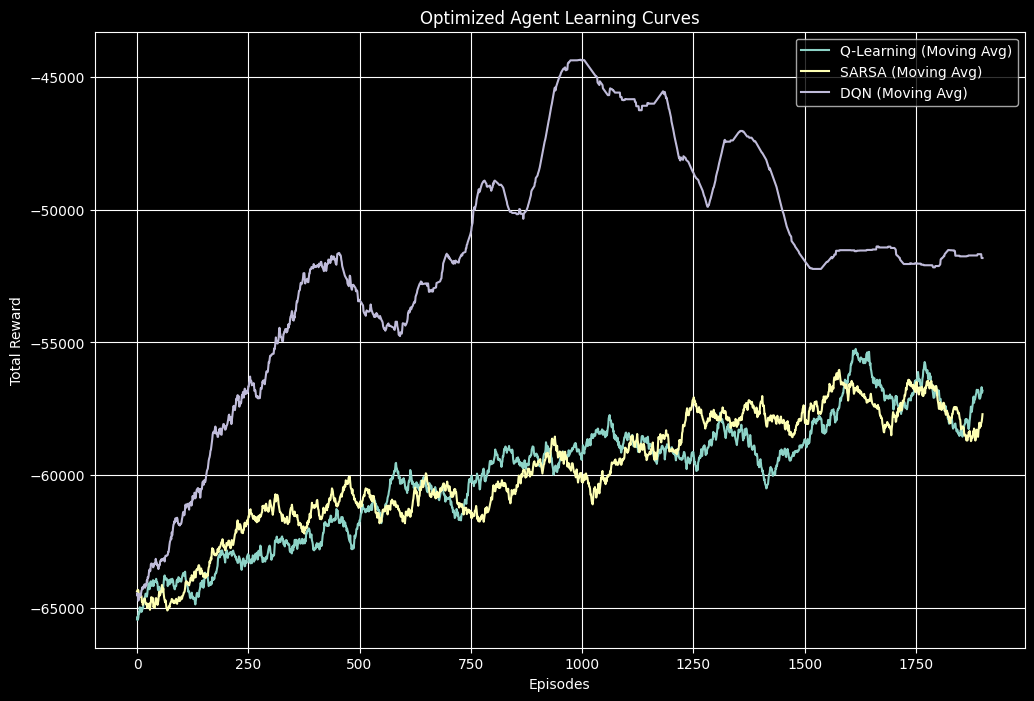

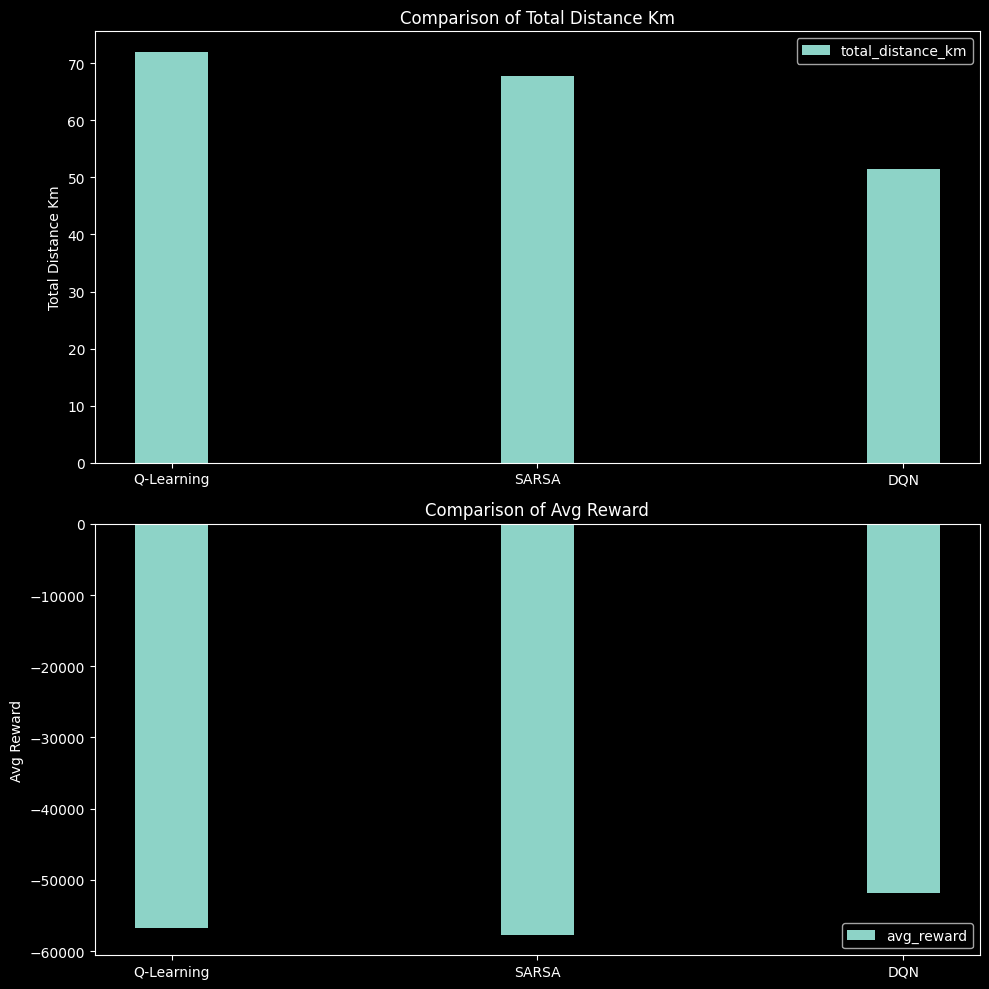

OSMnx route map saved to best_route_middlesbrough_final.png
Route map saved to best_route_final.html
Visualizations saved to disk.


In [61]:
# Cell 11: Generate Visualizations
print("\n--- Generating Visualizations ---")
# Plot learning curves comparison
plot_tuning_impact(initial_reward_histories, optimized_reward_histories)
plot_learning_curves(optimized_reward_histories, title="Optimized Agent Learning Curves")
plot_comparison(final_results)

# Plot route visualization
if env.osmnx_client:
    best_route_nodes = [env.nodes[i] for i in best_route_info["route"]]
    plot_osmnx_route(env.osmnx_client.G, best_route_nodes, file_path=f"best_route_{CITY.lower()}_final.png")
    plot_delivery_route(locations=env.locations, route=best_route_info["route"], file_path="best_route_final.html")
else:
    plot_delivery_route(locations=env.locations, route=best_route_info["route"], file_path="best_route_final.html")

print("Visualizations saved to disk.")